In [17]:
import os
import os.path as op
import coinsmeg_data as coinsmeg
from glob import glob
import pathlib
import mne
import re
import pandas as pd
import numpy as np

In [18]:
############## ------- Directories ---------- ############

# Directories
data_dir = "/Users/amyli/Desktop/phd/04-coins-meg/test-data"
maxfiltered_dir = f"{data_dir}/derivatives/maxfiltered"
aligned_dir = f"{data_dir}/derivatives/aligned"
#data_dir = coinsmeg.RAW_DIR # this is the same as BASE_DIR as raw data is stored in the base directory
#maxfiltered_dir = op.join(coinsmeg.DERIVATIVES_DIR, "maxfiltered") # the input
#aligned_dir = op.join(coinsmeg.DERIVATIVES_DIR, "aligned") # the output

# Get subjects
sub_run_combo = 'sub-04_run-4'
subject_id, run_id = sub_run_combo.split('_') # will produce subject_id = 'sub-XX', run_id = 'run-X'
run_number = int(re.search(r'\d+', run_id).group()) # extract number after 'run-

In [19]:
fif_file = f'{maxfiltered_dir}/{subject_id}/{subject_id}_ses-2-meg_task-coinsmeg_{run_id}_meg_transsss.fif'
beh_file = "/Users/amyli/Desktop/phd/04-coins-meg/test-data/sub-04/ses-2/beh/sub-04_ses-2-meg_task-coinsmeg_run-4.csv"

In [20]:
beh_file

'/Users/amyli/Desktop/phd/04-coins-meg/test-data/sub-04/ses-2/beh/sub-04_ses-2-meg_task-coinsmeg_run-4.csv'

In [21]:
coinsmeg.EVENT_ID

{'blockEnd': 20,
 'blockStart': 10,
 'expEnd': 105,
 'expStart': 100,
 'keyDown': 6,
 'keyLeft': 4,
 'keyRelease': 7,
 'keyRight': 3,
 'keyUp': 5,
 'laserHit': 1,
 'laserMiss': 2}

In [22]:
valid_triggers = list(coinsmeg.EVENT_ID.values())
overlapTriggers = [value + 1 for value in valid_triggers] + [value + 2 for value in valid_triggers]

In [23]:
minLaserDist = 0.08

In [24]:
############ ============== REQUIRED FUNCTIONS ========================= ##################

def calculate_block_times(raw, all_events):
    """
    For an EEG dataset in MNE-Python, determines the start and end times of blocks.
    
    Parameters:
    - all_events: EEG events extracted from MNE Raw object 

    Returns:
    - eeg_block_times: A dictionary with block start and end indices, durations in minutes, 
                       and start/end times in seconds.
    """
    trig_values = all_events[:, 2]  # Event trigger values

    # Identify Block Start and End Indices
    trig_blockStart = coinsmeg.EVENT_ID['blockStart']
    trig_blockEnd = coinsmeg.EVENT_ID['blockEnd']

    blockStart_idx = np.where(trig_values == trig_blockStart)[0]
    blockEnd_idx = np.where(trig_values == trig_blockEnd)[0]

    if len(blockStart_idx) != 4 or len(blockEnd_idx) != 4:
        raise ValueError("Wrong number of block triggers detected")
    else:
        print("THere are four block start and end triggers.")

    # Calculate Block Durations (in minutes)
    # Convert the sample times to actual time in seconds
    blockStart_times = raw.times[all_events[blockStart_idx, 0]]
    blockEnd_times = raw.times[all_events[blockEnd_idx, 0]]

    block_durations = (blockEnd_times - blockStart_times) / 60  # Convert seconds to minutes

    # Warn about Suspicious Block Durations
    if any(block_durations > 4) or any(block_durations < 3):
        print("Warning: Suspicious block durations")

    # Collect and Return Block Information
    eeg_block_times = {
        'eventIndices': np.column_stack((blockStart_idx, blockEnd_idx)),
        'durationsInMin': block_durations,
        'bordersInSecs': np.column_stack((blockStart_times, blockEnd_times))
    }

    return eeg_block_times


In [25]:
def extract_py_events(blockData, block_i):
        
    """
    From a session's csv file, extract csv events for the specified block. 
    Note there are four blocks in every session csv file.
    """

    blockData_currBlock = blockData[blockData.blockID == block_i]
    nFrames = blockData_currBlock['currentFrame'].iloc[-1]# Get the last element of blockData['currentFrame']
    # convert timestamps in frames to time unit (seconds)
    fsample = 60
    py_times = np.arange(0, nFrames / fsample, 1 / fsample)
    # find indices in triggerValue where the value is greater than 0 (i.e., a trigger was sent)
    py_trigIndex_blockSpace = np.where(blockData_currBlock['triggerValue'] > 0)[0] # which row of framewise block data has trigger
    py_trig_rows = blockData_currBlock.iloc[py_trigIndex_blockSpace]

    py_times = py_times[py_trigIndex_blockSpace]
    py_vals = py_trig_rows.triggerValue

    py_start_value = py_vals[0]
    if py_start_value !=  coinsmeg.EVENT_ID['laserHit'] and py_start_value != coinsmeg.EVENT_ID['laserMiss']:
        print('first trigger in csv file for the block is not a laser event')

    py_trigIndex_trigSpace = np.arange(1, len(py_vals) + 1)

    return py_times, py_vals, py_start_value, py_trigIndex_trigSpace, py_trigIndex_blockSpace


In [26]:
def extract_eeg_and_align_start(raw, all_events, eeg_block_times, block_i, py_start_value):
   
    #### ======== Extract EEG events for the specified block   ========== ####

    # Step 1: Extract EEG events for the specified block
    start_idx, end_idx = eeg_block_times['eventIndices'][block_i-1] # get the block_i-1 element of eventIndices; contains start and end time of n block
    eegEvents = all_events[start_idx:end_idx + 1]  # MNE events are indexed as [start:end+1] in Python

    # Extract sample times and event codes for the current block
    eeg_times = raw.times[eegEvents[:, 0]]  # Convert sample indices to times in seconds
    eeg_vals = eegEvents[:, 2]            # Extract the event codes (values) for these events

    #### Align EEG time with csv times by setting the first matching event time to zero ####

    tmpIdx = np.where(eeg_vals == py_start_value)[0] # gets the indices of elements of eeg_vals that match py_start_value
    if len(tmpIdx) == 0:
        raise ValueError("No matching event found in EEG for the specified py_start_value.")

    # Get the first event in the EEG file which equals the first event of csv file
    # and get the time (in eeg recording) when it happened
    eegStartTimeOffset = eeg_times[tmpIdx[0]] # this is the same thing as 'how much earlier did eeg recording start compared to first csv event'

    # Subtract the offset to align times, setting the first matching event to time zero
    eeg_times = eeg_times - eegStartTimeOffset

    # Step 3: Calculate sample indices for the start and end of the block
    # Find the sample indices that correspond to the start and end times of the block
    eegStartSample = raw.time_as_index(eeg_block_times['bordersInSecs'][block_i-1, 0])[0] # time_as_index coverts seconds to indices, accounting for srate 
    eegEndSample = raw.time_as_index(eeg_block_times['bordersInSecs'][block_i-1, 1])[0] # both lines return an array of a single element, but we need [0] anyway to extract the element

    return eeg_times, eeg_vals, eegStartTimeOffset, eegStartSample, eegEndSample


In [27]:
# Load in EEG data and wrangle the events a bit

raw = mne.io.read_raw_fif(fif_file, preload=True)
all_events = mne.find_events(raw, min_duration=0.005)

Opening raw data file /Users/amyli/Desktop/phd/04-coins-meg/test-data/derivatives/maxfiltered/sub-04/sub-04_ses-2-meg_task-coinsmeg_run-4_meg_transsss.fif...
    Range : 5000 ... 837999 =      5.000 ...   837.999 secs
Ready.
Reading 0 ... 832999  =      0.000 ...   832.999 secs...


/var/folders/d8/3my3_3ms1fd0jlggxb_8xr8m0000gn/T/ipykernel_14377/402921016.py:3: RuntimeWarning: This filename (/Users/amyli/Desktop/phd/04-coins-meg/test-data/derivatives/maxfiltered/sub-04/sub-04_ses-2-meg_task-coinsmeg_run-4_meg_transsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(fif_file, preload=True)


2867 events found
Event IDs: [  1   2   3   4   5   6   7  10  20 100 105]


In [28]:
blockData = pd.read_csv(beh_file,usecols=range(12))
block_i = 1

In [29]:
py_times, py_vals, py_start_value, py_trigIndex_trigSpace, py_trigIndex_blockSpace = extract_py_events(blockData, 1)

In [30]:
## Now the EEG triggers
eeg_block_times = calculate_block_times(raw, all_events)

THere are four block start and end triggers.


In [31]:
eeg_times, eeg_vals, eegStartTimeOffset, eegStartSample, eegEndSample = extract_eeg_and_align_start(raw, all_events, eeg_block_times, block_i, py_start_value)

In [32]:
## Save a copy before working on it
eeg_times_orig = eeg_times.copy()
eeg_vals_orig = eeg_vals.copy()
py_times_orig = py_times.copy()
py_vals_orig = py_vals.copy()

In [46]:
# run cell to reset
eeg_times = eeg_times_orig
eeg_vals = eeg_vals_orig
py_times = py_times_orig
py_vals = py_vals_orig

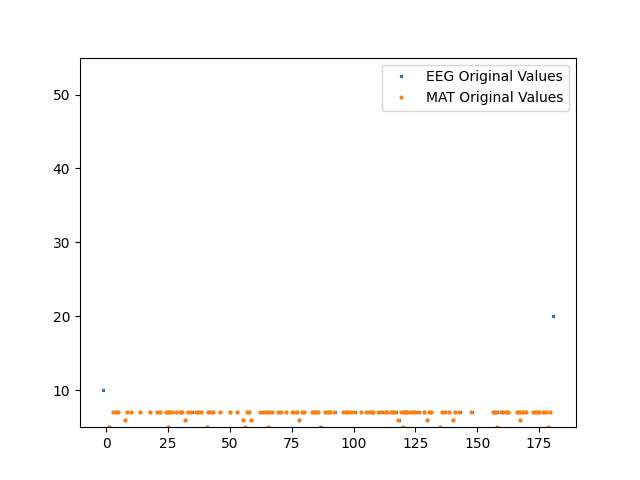

In [38]:
# visualise to see where problems lie first before aligning triggers
%matplotlib widget
import matplotlib.pyplot as plt

# Create the figure
plt.figure()

# Plot eegTimesOrig and eegValuesOrig with 'x' marker
plt.plot(eeg_times_orig, eeg_vals_orig, 'x', label='EEG Original Values', markersize=2)

# Hold on and plot matTimesOrig and matValuesOrig with 'o' marker
plt.plot(py_times_orig, py_vals_orig, 'o', label='MAT Original Values', markersize=2)

# Set y-axis limits
plt.ylim([5, 55])

# Show legend
plt.legend()

# Show plot
plt.show()


### Now the trickier aligning fun begins...

In [73]:
# Initialize assignments and tracking arrays
assignments = np.zeros(len(eeg_vals), dtype=int)  # Track number of assignments per EEG event
assigned_py_trigs = [[] for _ in range(len(eeg_vals))]  # Track assigned csv triggers
unassigned_py_trigs_idx = []  # Track unassigned csv triggers


In [18]:
# Find the indices of eeg_vals that are not in py_vals (the csv file containing ground-truth trigger values)
#toremove = ~np.isin(eeg_vals, py_vals)

In [19]:
# Remove those indices from eeg_vals and eeg_times
#eeg_vals = eeg_vals[~toremove]
#eeg_times = eeg_times[~toremove]

In [74]:
iteration = 0

for py_idx, py_val in enumerate(py_vals): # results in a idx, val pair
    
    # for testing X iterations
    if iteration >= 3:
        break
    
    # Find potential EEG triggers with matching values
    potEEGtrigs = np.where(eeg_vals == py_val)[0] # returns list of indices of elements in eeg_vals that has the same value as the current py_value trigger 
    
    if len(potEEGtrigs) == 0:
        # No matching EEG value found for the csv event
        print("Warning: Unassigned py event because no matching EEG value found...")
        unassigned_py_trigs_idx.append(py_idx)
    else:
        # Find the closest EEG trigger by time
        time_diffs = np.abs(eeg_times[potEEGtrigs] - py_times[py_idx])
        idx = np.argmin(time_diffs)  # Index of the closest time match
        closest_eeg_idx = potEEGtrigs[idx]

        # Assign the csv trigger to this EEG trigger
        assignments[closest_eeg_idx] += 1 # add a 1 to the location where there is a closest match
        
        # Check for multiple assignments to the same EEG trigger
        if assignments[closest_eeg_idx] > 1:
            # Double assignment detected - resolve based on timing

            # Times of the csv events in question
            t1 = py_times[assigned_py_trigs[closest_eeg_idx][0]]
            t2 = py_times[py_idx]

            print('t1 = ', t1, ' and t2 = ', t2)
            
            # Check if the two csv events are very close in time
            if t2 - t1 < minLaserDist:
                flagMissedEEG = True
            else:
                flagMissedEEG = False
            print('flagMissedEEG = ', flagMissedEEG)
            
            # Calculate delays for each assignment
            delay1 = t1 - eeg_times[closest_eeg_idx]
            delay2 = t2 - eeg_times[closest_eeg_idx]
            print('delay1 = ', delay1, ' and delay2 = ', delay2)

            # Estimate the current average delay
            try:
                indices2use = potEEGtrigs[max(0, idx - 10):idx] # indices2use is for calculating average delay
            except IndexError:
                indices2use = potEEGtrigs[:idx]
            
            indices2use = indices2use[assignments[indices2use] > 0]  # use only indices which are not non-zero
            
            if len(indices2use) > 0:
                currentDelay = np.mean(py_times[np.array(assigned_py_trigs)[indices2use]] - eeg_times[indices2use])
            else:
                currentDelay = 0
                
            print('currentDelay =', currentDelay)

            # Decide which csv event fits better
            if np.sign(delay1) != np.sign(delay2):
                betterFit = 'first' if np.sign(currentDelay) == np.sign(delay1) else 'second'
            else:
                betterFit = 'first' if abs(delay1 - currentDelay) < abs(delay2 - currentDelay) else 'second'

            # Reassign based on the better fit
            if betterFit == 'first':
                assignments[closest_eeg_idx] = 1
                if not flagMissedEEG:
                    # Assign the next closest EEG trigger
                    next_idx = potEEGtrigs[idx + 1] if idx + 1 < len(potEEGtrigs) else None
                    if next_idx is not None:
                        assignments[next_idx] += 1
                        assigned_py_trigs[next_idx].append(py_idx)
                    else:
                        unassigned_py_trigs_idx.append(py_idx)
                else:
                    unassigned_py_trigs_idx.append(py_idx)
            else:
                # Replace the assignment with the current csv event
                prev_csv = assigned_py_trigs[closest_eeg_idx][0]
                assigned_py_trigs[closest_eeg_idx] = [py_idx]
                if not flagMissedEEG:
                    # Try to reassign previous csv event to another EEG trigger
                    prev_idx = potEEGtrigs[idx - 1] if idx - 1 >= 0 else None
                    if prev_idx is not None and assignments[prev_idx] < 1:
                        assignments[prev_idx] += 1
                        assigned_py_trigs[prev_idx].append(prev_csv)
                    else:
                        unassigned_py_trigs_idx.append(prev_csv)
                else:
                    unassigned_py_trigs_idx.append(prev_csv)
        
        else: # if no double assignment detected 
            # Standard assignment without double assignments
            assigned_py_trigs[closest_eeg_idx].append(py_idx)
            
    print(assigned_py_trigs)

[[], [0], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

/var/folders/d8/3my3_3ms1fd0jlggxb_8xr8m0000gn/T/ipykernel_14377/1757779475.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  currentDelay = np.mean(py_times[np.array(assigned_py_trigs)[indices2use]] - eeg_times[indices2use])


IndexError: arrays used as indices must be of integer (or boolean) type